In [26]:
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.metrics import roc_auc_score

%matplotlib inline

I'll be demonstrating just the classification problems , you can build regression following a very similar process

In [27]:
# data prep from previous module
file=r'/Users/ed/Dropbox/Python/Dataset/Data/Data/census_income.csv'

ci_train=pd.read_csv(file)

# if you have a test data, you can combine as shown in the earlier modules

In [28]:
ci_train.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,Y
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [29]:
pd.crosstab(ci_train['education'],ci_train['education.num'])

education.num,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
education,,,,,,,,,,,,,,,,
10th,0,0,0,0,0,933,0,0,0,0,0,0,0,0,0,0
11th,0,0,0,0,0,0,1175,0,0,0,0,0,0,0,0,0
12th,0,0,0,0,0,0,0,433,0,0,0,0,0,0,0,0
1st-4th,0,168,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5th-6th,0,0,333,0,0,0,0,0,0,0,0,0,0,0,0,0
7th-8th,0,0,0,646,0,0,0,0,0,0,0,0,0,0,0,0
9th,0,0,0,0,514,0,0,0,0,0,0,0,0,0,0,0
Assoc-acdm,0,0,0,0,0,0,0,0,0,0,0,1067,0,0,0,0
Assoc-voc,0,0,0,0,0,0,0,0,0,0,1382,0,0,0,0,0


In [30]:
ci_train.drop(['education'],axis=1,inplace=True)

In [31]:
ci_train['Y'].value_counts().index

Index([' <=50K', ' >50K'], dtype='object')

In [32]:
ci_train['Y']=(ci_train['Y']==' >50K').astype(int)

In [33]:
cat_cols=ci_train.select_dtypes(['object']).columns

In [34]:
cat_cols

Index(['workclass', 'marital.status', 'occupation', 'relationship', 'race',
       'sex', 'native.country'],
      dtype='object')

In [35]:
ci_train.shape

(32561, 14)

In [36]:
for col in cat_cols:
    freqs=ci_train[col].value_counts()
    k=freqs.index[freqs>500][:-1]
    for cat in k:
        name=col+'_'+cat
        ci_train[name]=(ci_train[col]==cat).astype(int)
    del ci_train[col]
    print(col)

workclass
marital.status
occupation
relationship
race
sex
native.country


In [37]:
ci_train.shape

(32561, 39)

In [38]:
ci_train.isnull().sum()

age                                   0
fnlwgt                                0
education.num                         0
capital.gain                          0
capital.loss                          0
hours.per.week                        0
Y                                     0
workclass_ Private                    0
workclass_ Self-emp-not-inc           0
workclass_ Local-gov                  0
workclass_ ?                          0
workclass_ State-gov                  0
workclass_ Self-emp-inc               0
marital.status_ Married-civ-spouse    0
marital.status_ Never-married         0
marital.status_ Divorced              0
marital.status_ Separated             0
occupation_ Prof-specialty            0
occupation_ Craft-repair              0
occupation_ Exec-managerial           0
occupation_ Adm-clerical              0
occupation_ Sales                     0
occupation_ Other-service             0
occupation_ Machine-op-inspct         0
occupation_ ?                         0


In [39]:
x_train=ci_train.drop(['Y'],1)
y_train=ci_train['Y']

In [41]:
y_train.value_counts()

0    24720
1     7841
Name: Y, dtype: int64

## Hyper Parameters For Decision Trees

* criterion : there are two options available , "entropy" and "gini". These are the homogeneity measures that we discussed. By default "gini" is used 

* The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples. Ignored if ``max_leaf_nodes`` is not None. We'll finding optimal value for max_leaf_nodes [which is basically size of the tree] through cross validation.

* min_sample_split : The minimum number of samples required to split an internal node. defaults to too, good idea is to keep it slightly higher in order to reduce overfitting of the data. recommended values is between 5 to 10

* min_sample_leaf : The minimum number of samples required to be at a leaf node. This defaults to 1. If this number is higher and a split results in a leaf node having lesser number of samples than specified then that split is cancelled.

* max_leaf_node : this parameter controlls size of the tree, we'll be finding optimal value of this through cross validation

* class_weight : this default to None in which case each class is given equal weightage. If the goal of the problem is good classification instead of accuracy then you should set this to "balanced", in which case class weights are assigned inversely proportional to class frequencies in the input data.

* random_state : this is used to reproduce random result


In [42]:
from sklearn.model_selection import RandomizedSearchCV

In [43]:
params={ 'class_weight':[None,'balanced'], 
        'criterion':['entropy','gini'],
        'max_depth':[None,5,10,15,20,30,50,70],
            'min_samples_leaf':[1,2,5,10,15,20], 
            'min_samples_split':[2,5,10,15,20]
       }

In [44]:
2*2*8*6*5

960

In [45]:
from sklearn.tree import DecisionTreeClassifier

In [46]:
clf=DecisionTreeClassifier()

In [47]:
random_search=RandomizedSearchCV(clf,cv=10,
                                 param_distributions=params,
                                 scoring='roc_auc',
                                 n_iter=10
                                    )

In [48]:
random_search.fit(x_train,y_train)

RandomizedSearchCV(cv=10, error_score='raise-deprecating',
                   estimator=DecisionTreeClassifier(class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort=False,
                                                    random_state=None,
                                                    splitter='best'

Printing the tree model is a little tricky in python. We'll have to output our tree to a .dot file using graphviz package. From there using graphviz.Source function we can print our tree for display. Here is how :

In [50]:
random_search.cv_results_

{'mean_fit_time': array([0.13313053, 0.09720023, 0.14045463, 0.1617924 , 0.09142513,
        0.09776897, 0.13815331, 0.10813081, 0.08958385, 0.12401106]),
 'std_fit_time': array([0.00989578, 0.00236719, 0.01131525, 0.0157759 , 0.00248435,
        0.00162641, 0.00259033, 0.00219217, 0.00105476, 0.00710593]),
 'mean_score_time': array([0.00260394, 0.00251803, 0.00258212, 0.00287805, 0.0024404 ,
        0.00240176, 0.00250285, 0.00242078, 0.00237639, 0.00245733]),
 'std_score_time': array([0.00025561, 0.0002257 , 0.0002346 , 0.00041821, 0.00018406,
        0.00016019, 0.0001173 , 0.0001069 , 0.00010062, 0.00014801]),
 'param_min_samples_split': masked_array(data=[10, 15, 5, 10, 5, 15, 15, 10, 15, 20],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_min_samples_leaf': masked_array(data=[20, 15, 15, 5, 1, 1, 5, 20, 5, 1],
              mask=[False, False, False, False, 

In [49]:
random_search.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=15,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [53]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.8f} (std: {1:.5f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [54]:
report(random_search.cv_results_,5)

Model with rank: 1
Mean validation score: 0.90401764 (std: 0.00517)
Parameters: {'min_samples_split': 15, 'min_samples_leaf': 5, 'max_depth': 10, 'criterion': 'gini', 'class_weight': None}

Model with rank: 2
Mean validation score: 0.90381287 (std: 0.00386)
Parameters: {'min_samples_split': 15, 'min_samples_leaf': 15, 'max_depth': 10, 'criterion': 'entropy', 'class_weight': None}

Model with rank: 3
Mean validation score: 0.89920311 (std: 0.00465)
Parameters: {'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 10, 'criterion': 'gini', 'class_weight': None}

Model with rank: 4
Mean validation score: 0.89846967 (std: 0.00566)
Parameters: {'min_samples_split': 10, 'min_samples_leaf': 20, 'max_depth': 15, 'criterion': 'gini', 'class_weight': None}

Model with rank: 5
Mean validation score: 0.89584158 (std: 0.00630)
Parameters: {'min_samples_split': 15, 'min_samples_leaf': 1, 'max_depth': 10, 'criterion': 'gini', 'class_weight': 'balanced'}



In [55]:
dtree=random_search.best_estimator_

In [56]:
dtree.fit(x_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=15,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [57]:
dotfile = open("mytree.dot", 'w')

tree.export_graphviz(dtree,out_file=dotfile,
                     feature_names=x_train.columns,
                    class_names=["0","1"],
                     proportion=True)
dotfile.close()

In [59]:
import os
os.getcwd()

'/Users/ed/Dropbox/Python/Python ML/05.Decision Trees & Random Forests'

In [60]:
1-0.759*0.759-0.241*0.241

0.36583799999999994

In [61]:
0.122*0.54+0.494*0.46

0.29312

Open mytree.dot file in a simple text editor and copy and paste the code here to visualise your tree : http://webgraphviz.com

## Additional Hyper parameters for RandomForests

* n_estimators : number of trees in the forest . defaults to 10. good starting point will be 100. Its one of the hyper parameters. We'll see how to search through mutidimensional hyper parameter space in order to find optimal combination through randomised grid search

* max_features : Number of features being considered for rule selection at each split. Look at the documentation for defaults

* bootstrap : boolean values, Whether bootstrap samples are used when building trees.


In [62]:
from sklearn.ensemble import RandomForestClassifier

In [63]:
clf = RandomForestClassifier()

In [64]:
# this here is the base classifier we are going to try
# we will be supplying different parameter ranges to our randomSearchCV which in turn
# will pass it on to this classifier

# Utility function to report best scores. This simply accepts grid scores from 
# our randomSearchCV/GridSearchCV and picks and gives top few combination according to 
# their scores

# RandomSearchCV/GridSearchCV accept parameters values as dictionaries.
# In example given below we have constructed dictionary for 
#different parameter values that we want to
# try for randomForest model

param_dist = {"n_estimators":[100,200,300,500,700,1000],
              "max_features": [5,10,20,25,30,35],
              "bootstrap": [True, False],
              'class_weight':[None,'balanced'], 
                'criterion':['entropy','gini'],
                'max_depth':[None,5,10,15,20,30,50,70],
                'min_samples_leaf':[1,2,5,10,15,20], 
                'min_samples_split':[2,5,10,15,20]
                  }



In [65]:
x_train.shape

(32561, 38)

In [66]:
960*6*6*2

69120

In [67]:
# run randomized search
n_iter_search = 10
# n_iter parameter of RandomizedSeacrhCV controls, how many 
# parameter combination will be tried; out of all possible given values

random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search,scoring='roc_auc',cv=5)
random_search.fit(x_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [68]:
random_search.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=15, max_features=10, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=15, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features=10, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=10,
            min_samples_split=20, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
            
**Note: This is a result from one of the runs, you can very well get different results from a different run. Your results need not match with this.**

In [69]:
report(random_search.cv_results_,5)

Model with rank: 1
Mean validation score: 0.91770869 (std: 0.00331)
Parameters: {'n_estimators': 500, 'min_samples_split': 20, 'min_samples_leaf': 15, 'max_features': 10, 'max_depth': 15, 'criterion': 'gini', 'class_weight': None, 'bootstrap': True}

Model with rank: 2
Mean validation score: 0.91723056 (std: 0.00288)
Parameters: {'n_estimators': 500, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_features': 10, 'max_depth': 10, 'criterion': 'gini', 'class_weight': 'balanced', 'bootstrap': False}

Model with rank: 3
Mean validation score: 0.91609634 (std: 0.00372)
Parameters: {'n_estimators': 300, 'min_samples_split': 15, 'min_samples_leaf': 20, 'max_features': 25, 'max_depth': 20, 'criterion': 'gini', 'class_weight': 'balanced', 'bootstrap': True}

Model with rank: 4
Mean validation score: 0.91564539 (std: 0.00332)
Parameters: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 15, 'max_features': 30, 'max_depth': 30, 'criterion': 'entropy', 'class_weight': None, 'b

In [70]:
# select the best values from results above, they will vary slightly with each run
rf=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini', max_depth=50, 
                          max_features=10, max_leaf_nodes=None, min_impurity_split=1e-07, 
                          min_samples_leaf=10, min_samples_split=20, min_weight_fraction_leaf=0.0, 
                          n_estimators=300, n_jobs=1, oob_score=False, random_state=None, verbose=0, warm_start=False)

In [71]:
rf.fit(x_train,y_train)

/Users/ed/.local/lib/python3.7/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/Users/ed/.local/lib/python3.7/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/Users/ed/.local/lib/python3.7/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/Users/ed/.local/lib/python3.7/site-packages/sklearn/tree/tree.py:297: DeprecationWarnin

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=50, max_features=10, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=1e-07,
                       min_samples_leaf=10, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

## Feature Importance

In [72]:
feat_imp_df=pd.DataFrame({'features':x_train.columns,'importance':rf.feature_importances_})

feat_imp_df.sort_values('importance',ascending=False)

,features,importance
3,capital.gain,0.180652
12,marital.status_ Married-civ-spouse,0.167664
2,education.num,0.160151
28,relationship_ Husband,0.094373
0,age,0.082733
5,hours.per.week,0.052692
1,fnlwgt,0.044140
4,capital.loss,0.041067
13,marital.status_ Never-married,0.028600
18,occupation_ Exec-managerial,0.027385


## Partial Dependence Plot



In [81]:
var_name='education.num'

preds=rf.predict_proba(x_train)[:,1]
# part_dep_data

In [82]:
var_data=pd.DataFrame({'var':x_train[var_name],'response':preds})

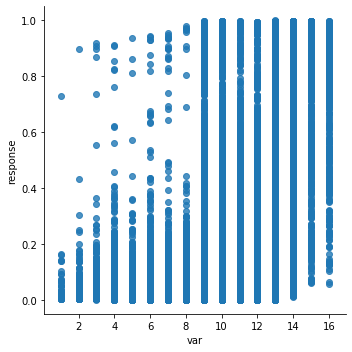

In [83]:
import seaborn as sns

sns.lmplot(x='var',y='response',data=var_data,fit_reg=False)

In [84]:
import statsmodels.api as sm
smooth_data=sm.nonparametric.lowess(var_data['response'],var_data['var'])

# smooth_data

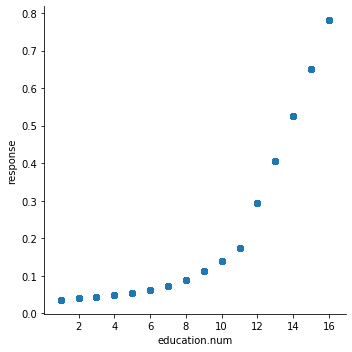

In [85]:
df=pd.DataFrame({'response':smooth_data[:,1],var_name:smooth_data[:,0]})

sns.lmplot(x=var_name,y='response',data=df,fit_reg=False)